!git clone https://github.com/ndb796/Scene-Classification-Dataset
%cd Scene-Classification-Dataset


* [SRGAN 논문(CVPR 2017)](https://arxiv.org/abs/1609.04802)
* [Scene Classification 데이터셋](https://github.com/ndb796/Scene-Classification-Dataset)



In [1]:
from torch import nn
import torch

from torchvision.models import vgg19

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.feature_extractor = nn.Sequential(
            *list(vgg19(pretrained=True).features.children())[:18]
        )

    def forward(self, img):
        return self.feature_extractor(img)

print(FeatureExtractor())
print(FeatureExtractor()(torch.zeros((4, 3, 256, 256))).shape)

/home/minhyuk/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/minhyuk/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FeatureExtractor(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        kernel_size = 3
        out_channels = 64
        stride = 1
        padding = kernel_size // 2
        self.conv_block = nn.Sequential(
            nn.Conv2d(
                in_features, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Conv2d(
                out_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return x + self.conv_block(x)

print(ResidualBlock(64))
ResidualBlock(64)(torch.zeros((3, 64, 128, 128))).shape

ResidualBlock(
  (conv_block): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


torch.Size([3, 64, 128, 128])

In [3]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()
        layers = []
        # First layer: k9n64s1
        self.first_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=64, kernel_size=9, stride=1, padding=4),
            nn.PReLU(),
        )

        # Residual blocks: k3n64s1을 16번 반복
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(in_features=64) for _ in range(16)]
        )

        # conv layer post residual blocks: k3n64s1
        self.conv_layer_post_residual_blocks = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=64),
        )

        # Upsampling layers: k3n256s1을 2번 반복 (pixel suffle 사용,upscale_factor=2)
        self.upsampling_layers = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=64,
                        out_channels=256,
                        kernel_size=3,
                        stride=1,
                        padding=1,
                    ),
                    nn.PixelShuffle(2),
                    nn.PReLU(),
                )
                for _ in range(2)
            ]
        )

        # Final output layer: k9n3s1
        self.output_layer = nn.Conv2d(
            in_channels=64, out_channels=3, kernel_size=9, stride=1, padding=4
        )

    def forward(self, x):
        x = self.first_layer(x)
        x0 = x
        x1 = self.residual_blocks(x)
        x1 = self.conv_layer_post_residual_blocks(x1)
        x = x0 + x1
        x = self.upsampling_layers(x)
        out = self.output_layer(x)
        return out
print(GeneratorResNet())
GeneratorResNet()(torch.zeros((4, 3, 128, 128))).shape

GeneratorResNet(
  (first_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

torch.Size([4, 3, 512, 512])

In [4]:
class DisConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1) -> None:
        super(DisConvBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                stride=stride,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.layers(x)

print(DisConvBlock(64, 128))
print(DisConvBlock(64, 128)(torch.zeros((4, 64, 256, 256))).shape)
print(DisConvBlock(128, 128, 2))
print(DisConvBlock(128, 128, 2)(torch.zeros((4, 128, 256, 256))).shape)

DisConvBlock(
  (layers): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
)
torch.Size([4, 128, 256, 256])
DisConvBlock(
  (layers): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
)
torch.Size([4, 128, 128, 128])


In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        in_channels, height, width = input_shape
        self.output_shape = (1, height // 16, width // 16)
        self.first_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
        )
        config = [[64, 2], [128, 1], [128, 2], [256, 1], [256, 2], [512, 1], [512, 2]]
        self.conv_blocks = nn.Sequential(
            *[
                DisConvBlock(
                    in_channels=config[idx - 1][0],
                    out_channels=config[idx][0],
                    stride=config[idx][1],
                )
                if idx > 0
                else DisConvBlock(
                    in_channels=64, out_channels=config[idx][0], stride=config[idx][1]
                )
                for idx in range(len(config))
            ]
        )
        self.last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1, kernel_size=3, stride=1, padding=1
            ),
        ) 

    def forward(self, img):
        x = self.first_layer(img)
        x = self.conv_blocks(x)
        return self.last_layer(x)

print(Discriminator((3, 128, 128)))
print(Discriminator((3, 128, 128))(torch.zeros((4, 3, 128, 128))).shape)

Discriminator(
  (first_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (conv_blocks): Sequential(
    (0): DisConvBlock(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (1): DisConvBlock(
      (layers): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (2): DisConvBlock(
      (layers): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1

In [6]:
import glob
import numpy as np
from PIL import Image

from torch.utils.data import Dataset
import torchvision.transforms as transforms

# 정규화(normalization) 파라미터(parameters) for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


# 흑백 이미지를 RGB 색상 이미지로 변환
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image


class ImageDataset(Dataset):
    def __init__(self, root, hr_shape):
        hr_height, hr_width = hr_shape
        # 저해상도(low resolution) 이미지를 만드는 변환(transform) 객체
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        # 고해상도(high resolution) 이미지를 만드는 변환(transform) 객체
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )

        self.files = sorted(glob.glob(root + '/*.*'))
    
    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])

        # 흑백(grayscale) 이미지를 색상 이미지로 변환
        if img.mode != 'RGB':
            img = to_rgb(img)
        
        img_lr = self.lr_transform(img) # 저해상도(low resolution) 이미지
        img_hr = self.hr_transform(img) # 고해상도(high resolution) 이미지

        return {"lr": img_lr, "hr": img_hr}
    
    def __len__(self):
        return len(self.files)

In [7]:
import os
from types import SimpleNamespace


os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

opt = SimpleNamespace()
opt.epoch = 0 # 현재 실행에서 학습을 재개할 에폭(epoch)
opt.n_epochs = 200 # 학습을 위한 총 에폭(epoch)
opt.dataset_name = '../dataset/scene/train-scene classification/train' # 학습할 이미지가 포함된 폴더명
opt.batch_size = 8 # 배치 크기(batch size)
opt.lr = 0.0002 # Adam 최적화를 위한 학습률(learning rate)
opt.b1 = 0.5 # Adam을 위한 파라미터
opt.b2 = 0.999 # Adam을 위한 파라미터
opt.decay_epoch = 100 # 학습률(learning rate) decay를 시작할 에폭(epoch)
opt.n_cpu = 4 # CPU 쓰레드(thread) 수
opt.hr_height = 128 # 고해상도(high resolution) 이미지의 높이(height)
opt.hr_width = 128 # 고해상도(high resolution) 이미지의 너비(width)
opt.channels = 3 # 이미지의 채널(channel) 크기
opt.sample_interval = 100 # 이미지를 저장할 배치 간격(interval)
print(opt)

namespace(epoch=0, n_epochs=200, dataset_name='../dataset/scene/train-scene classification/train', batch_size=8, lr=0.0002, b1=0.5, b2=0.999, decay_epoch=100, n_cpu=4, hr_height=128, hr_width=128, channels=3, sample_interval=100)


In [8]:
cuda = torch.cuda.is_available()
hr_shape = (opt.hr_height, opt.hr_width)

# 생성자(generator) 및 판별자(discriminator) 초기화
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(opt.channels, *hr_shape))

# 특징 추출기를 초기화하고 추론(inference) 모드로 변경
feature_extractor = FeatureExtractor()
feature_extractor.eval()

# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

# GPU 기기로 옮기기
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

# optimizers 초기화
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [9]:
import time

from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.autograd import Variable


Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

dataloader = DataLoader(
    ImageDataset("./%s" % opt.dataset_name, hr_shape=hr_shape),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu,
)

start_time = time.time() 

for epoch in range(opt.epoch, opt.n_epochs):
    for i, imgs in enumerate(dataloader):

        # disccriminator 입력 영상
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        

        # disccriminator ground-truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # 생성자(generator) 학습-----------------------------------
        optimizer_G.zero_grad()
        
        imgs_sr = generator(imgs_lr)
        preds_sr = discriminator(imgs_sr)
        loss_adversarial = criterion_GAN(preds_sr, valid)

        feature_hr = feature_extractor(imgs_hr)
        feature_sr = feature_extractor(imgs_sr)
        loss_content =  criterion_content(feature_hr, feature_sr)

        loss_generative = loss_content + 0.001 * loss_adversarial
        
        loss_generative.backward()
        optimizer_G.step()

        # 판별자(discriminator) 학습-----------------------------------
        optimizer_D.zero_grad()
        
        imgs_sr = generator(imgs_lr)
        preds_hr = discriminator(imgs_hr)
        preds_sr = discriminator(imgs_sr)

        loss_adversarial_hr = criterion_GAN(preds_hr, valid)
        loss_adversarial_sr = criterion_GAN(preds_sr, fake)
        loss_discriminator = loss_adversarial_hr + loss_adversarial_sr

        loss_discriminator.backward()
        optimizer_D.step()
        print(
            f'\repoch:{epoch+1}/{opt.n_epochs} batch:{i + 1:4d}/{len(dataloader)}'
            + f' | pd:{preds_hr.mean():.4f}'
            + f' | pg:{preds_sr.mean():.4f}'
            + f' | ld:{loss_discriminator:.4f}'
            + f' | lg:{loss_generative:.4f}'
            + f' | lc:{loss_content:.4f}'
            + f' | la:{loss_adversarial:.4f}',
            end='' if i % 507 != 0 else '\n',
        )

    torch.save(generator.state_dict(), f'output/srgan_generator.pth')
    torch.save(discriminator.state_dict(), f'output/srgan_discriminator.pth')


epoch:1/200 batch:   1/3042 | pd:-0.2239 | pg:-0.2112 | ld:1.7395 | lg:1.2519 | lc:1.2504 | la:1.5638
epoch:1/200 batch: 508/3042 | pd:0.9809 | pg:-0.0243 | ld:0.0030 | lg:1.4452 | lc:1.4442 | la:1.0500
epoch:1/200 batch:1015/3042 | pd:1.0380 | pg:0.0297 | ld:0.0036 | lg:1.2476 | lc:1.2466 | la:0.94035
epoch:1/200 batch:1522/3042 | pd:1.0140 | pg:-0.0001 | ld:0.0007 | lg:1.0951 | lc:1.0941 | la:0.99994
epoch:1/200 batch:2029/3042 | pd:0.9926 | pg:-0.0110 | ld:0.0004 | lg:1.0418 | lc:1.0408 | la:1.0209
epoch:1/200 batch:2536/3042 | pd:0.9850 | pg:-0.0152 | ld:0.0007 | lg:1.0221 | lc:1.0211 | la:1.0309
epoch:2/200 batch:   1/3042 | pd:0.9954 | pg:0.0342 | ld:0.0022 | lg:0.9888 | lc:0.9879 | la:0.935475
epoch:2/200 batch: 508/3042 | pd:0.9948 | pg:0.0014 | ld:0.0003 | lg:1.0616 | lc:1.0606 | la:0.99781
epoch:2/200 batch:1015/3042 | pd:0.9921 | pg:-0.0072 | ld:0.0014 | lg:1.1399 | lc:1.1389 | la:1.0149
epoch:2/200 batch:1522/3042 | pd:0.9943 | pg:-0.0021 | ld:0.0002 | lg:1.0632 | lc:1.0622

torch.Size([3, 128, 128]) torch.Size([3, 128, 128]) torch.Size([3, 128, 128])


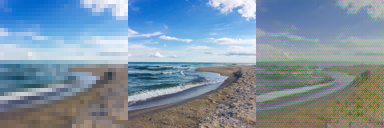

In [10]:
from IPython.display import Image as Display # to display images


# 저해상도(low resolution) 이미지를 만드는 변환(transform) 객체
lr_transform = transforms.Compose(
    [
        transforms.Resize((opt.hr_height // 4, opt.hr_height // 4), Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)
# 고해상도(high resolution) 이미지를 만드는 변환(transform) 객체
hr_transform = transforms.Compose(
    [
        transforms.Resize((opt.hr_height, opt.hr_height), Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

image = Image.open('../dataset/scene/custom_images/2.jpg')
lr_image = lr_transform(image).unsqueeze(0).cuda()
hr_image = hr_transform(image).unsqueeze(0).cuda()
hr_generated = generator(lr_image)

# Save image grid with upsampled inputs and SRGAN outputs
lr_image = nn.functional.interpolate(lr_image, scale_factor=4)
lr_image = make_grid(lr_image, nrow=1, normalize=True)
hr_image = make_grid(hr_image, nrow=1, normalize=True)
hr_generated = make_grid(hr_generated, nrow=1, normalize=True)
print(lr_image.shape, hr_image.shape, hr_generated.shape)
img_grid = torch.cat((lr_image, hr_image, hr_generated), -1)
save_image(img_grid, "result.png", normalize=False)

# 결과 이미지를 출력해보기
# 차례대로 [저해상도, 고해상도, 해상도 복원 결과]입니다.
Display(filename='result.png')